In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tqdm import tqdm

import nltk
nltk.download('punkt')

import tensorflow as tf
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.3.0


In [2]:
with open("/content/Dataset.txt") as f:
  Data = f.read()

In [3]:
Data = Data.lower()

In [4]:
Data = re.sub(r'[\n]', ' ', Data)
Data = re.sub(r'[\'"?!]', '', Data)
Data = re.sub(r'[.,]', ' ', Data)
Data = re.sub(r'[:;]', ' ', Data)
Data = re.sub(r'[0]', ' ', Data)
Data = re.sub(r'[1]', ' ', Data)
Data = re.sub(r'[\[\]]', ' ', Data)
Data = re.sub(r'[\-]', ' ', Data)

In [5]:
Data

'alberto took one look at his new neighbours and knew that his life was going to get more difficult  he watched them arrive in their big  noisy car and watched them get out  there they were  two of them  as big and as noisy as their car – and smelly and stupid as well   terrible he thought  how am i going to put up with them he went to tell mimi  mimi was the friend he lived with   have you seen the new neighbours he asked her   no  she said  who are they  two of them  the ones we don’t like  big and noisy and stupid and smelly  just like they always are   oh no  said mimi  how awful still  i suppose we can just ignore them   i suppose youre right  agreed alberto  well just have to ignore them   for a few days  then  alberto and mimi tried to ignore their new neighbours  when the neighbours went out for a walk  alberto and mimi didnt say hello to them  when the neighbours were in their garden  alberto and mimi went inside  this was ok for a few days  but  perhaps inevitably  things did

In [6]:
words = nltk.word_tokenize(Data)

In [7]:
word_to_index = {}
index_to_word = {}
count = 0
for word in words:
  if(word not in word_to_index.keys()):
    word_to_index[word] = count
    count = count + 1
for word in word_to_index.keys():
  index_to_word[word_to_index[word]] = word

In [8]:
def cooccurence_matrix(words, word_to_index, window_size):
  V = len(word_to_index)
  matrix = np.zeros(shape = (V, V))
  for i in range(len(words)):
    for j in range(i - window_size, i + window_size + 1, 1):
      if(j < 0 or j == i or j > (len(words) - 1)):
        continue
      increment = 1.0/(abs(i - j))
      matrix[word_to_index[words[i]]][word_to_index[words[j]]] = matrix[word_to_index[words[i]]][word_to_index[words[j]]] + increment
  return matrix

In [9]:
matrix = cooccurence_matrix(words, word_to_index, 10)

In [10]:
# matrix

In [11]:
def Weight_Intialization(V, n_Hidden):
  W1 = np.random.randn(V, n_Hidden)
  b1 = np.random.randn(V, 1)
  W2 = np.random.randn(V, n_Hidden)
  b2 = np.random.randn(V, 1)
  return W1, b1, W2, b2

In [12]:
def back_prop(W1, b1, W2, b2, x, x_max, V, learning_rate):
  global_cost = 0
  for i in range(V):
    for j in range(V):
      weight = ((x[i][j]/x_max)**2 if(x[i][j] < x_max) else 1)
      cost_inner = np.dot(W1[i], W2[j]) + b1[i] + b2[j] - (np.log(x[i][j]) if(x[i][j] != 0) else 0)
      cost = weight*(cost_inner**2)
      global_cost = global_cost + cost

      dW1 = weight*cost_inner*W2[j]
      dW2 = weight*cost_inner*W1[i]
      db1 = weight*cost_inner
      db2 = weight*cost_inner

      W1[i] = W1[i] - learning_rate*dW1
      W2[j] = W2[j] - learning_rate*dW2
      b1[i] = b1[i] - learning_rate*db1
      b2[j] = b2[j] - learning_rate*db2

  return W1, b1, W2, b2, global_cost  

In [13]:
def GloVe(x, word_to_index, epochs = 10, learning_rate = 0.0001, x_max = 10):
  V = len(word_to_index)
  n_Hidden = 300
  W1, b1, W2, b2 = Weight_Intialization(V, n_Hidden)
  for i in tqdm(range(epochs)):
    W1, b1, W2, b2, global_cost = back_prop(W1, b1, W2, b2, x, x_max, V, learning_rate)
  return W1, W2 

In [14]:
W1, W2 = GloVe(matrix, word_to_index, 100)

100%|██████████| 100/100 [03:41<00:00,  2.22s/it]


In [15]:
# W1

In [16]:
# W2

In [17]:
W = np.add(W1, W2)/2

In [18]:
W = W.T

In [19]:
# W.shape

In [20]:
word_to_vector = {}
for word in word_to_index.keys():
  word_to_vector[word] = W[:, word_to_index[word]]

In [21]:
# word_to_vector

In [22]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(W.T)

In [23]:
# principalComponents.shape

In [24]:
word_to_reduce_vector = {}
for word in word_to_index.keys():
  word_to_reduce_vector[word] = principalComponents[word_to_index[word], :]

In [25]:
# word_to_reduce_vector

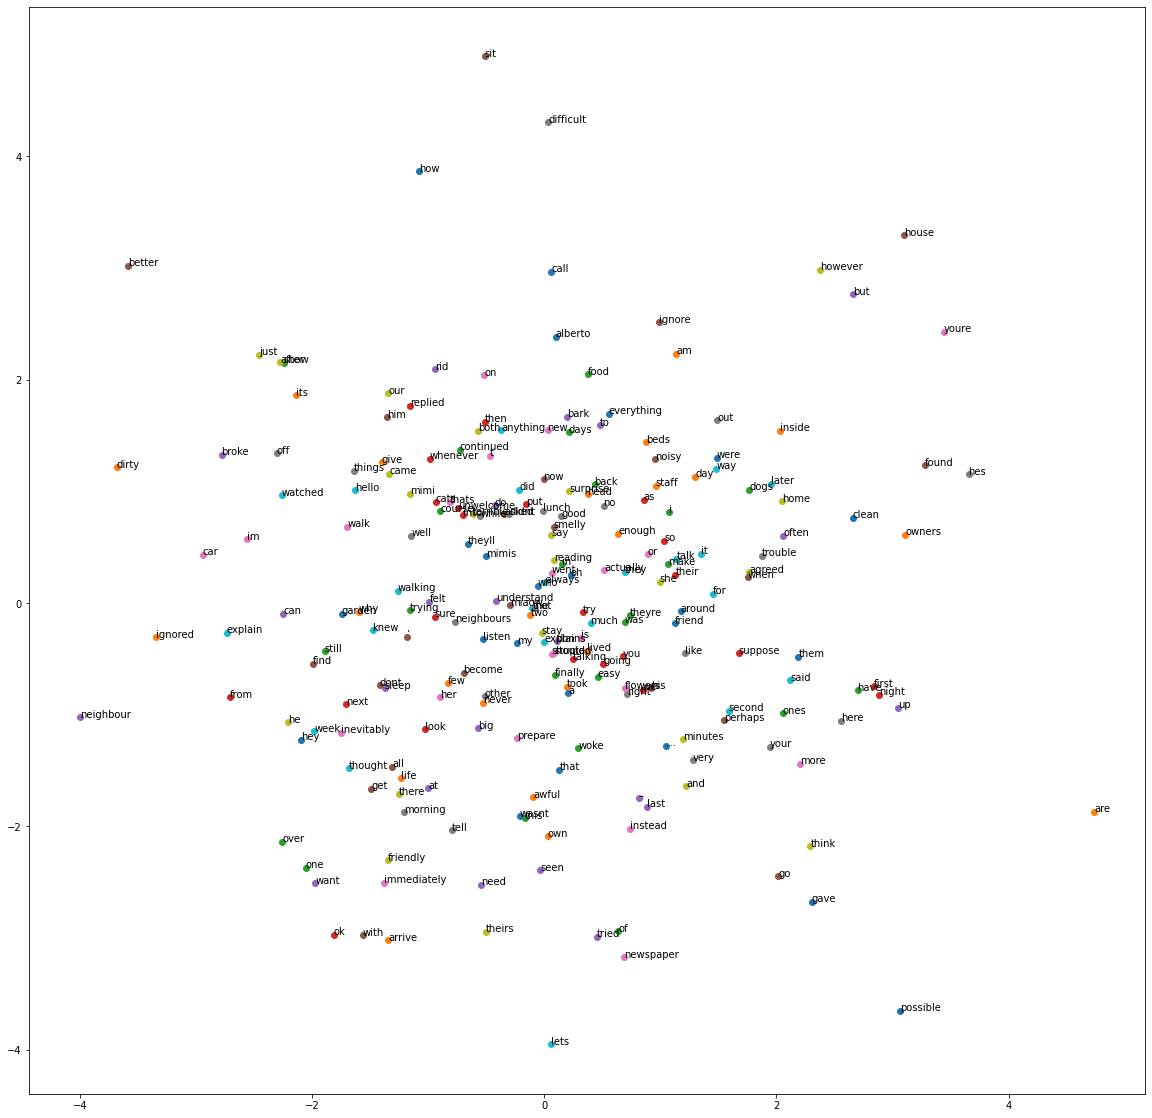

In [26]:
plt.figure(figsize = (20, 20))
for word, vector in word_to_reduce_vector.items():
  plt.scatter(vector[0], vector[1])
  plt.annotate(word, (vector[0], vector[1]))